In [1]:
import h5py
import tensorflow as tf
import keras
import dask.array as da
import seaborn as sns
#Check if GPU is being used and import other necessary libraries
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#Again, just import some necessary libraries as part of the preamble in training our dataset
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.initializers import TruncatedNormal, Zeros
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
#Just define some variables for the training set and test set
f = h5py.File("train_pile_10000000.h5", "r")
g = h5py.File("test_pile_5000000.h5", "r")

In [4]:
X_train = da.from_array(f['features'], chunks=(100000, 1, 32,32))
y_train =  da.from_array(f['targets'], chunks=(100000,1))
X_test = da.from_array(g['features'], chunks=(100000, 1, 32,32))
y_test =  da.from_array(g['targets'], chunks=(100000,1))

In [5]:
def dask_generator(X, y, batch_size):
    instances = X.shape[0]
    batches = instances // batch_size
    while True:
        for i in range(batches):
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]
            yield X_batch, y_batch

In [6]:
batch_size = 64
train = dask_generator(X_train, y_train, batch_size)
test = dask_generator(X_test, y_test, batch_size)

In [7]:
from DeepSaki.layers import FourierConvolution2D
custom_objects = {"FourierConvolution2D": FourierConvolution2D, "TruncatedNormal": TruncatedNormal,
                 "Zeros": Zeros}

# Load model
model1 = keras.models.load_model("ffcnnmodel.h5", custom_objects=custom_objects)
model2 = keras.models.load_model("conv2dmodel.h5")
model3 = keras.models.load_model("stackmodel.h5", custom_objects=custom_objects)

C:\Users\Sham\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#For F-FCNN

In [8]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 fourier_convolution2d_8 (Fo  (64, 32, 32, 32)         288       
 urierConvolution2D)                                             
                                                                 
 fourier_convolution2d_9 (Fo  (64, 32, 32, 32)         9216      
 urierConvolution2D)                                             
                                                                 
 max_pooling2d_3 (MaxPooling  (64, 32, 16, 16)         0         
 2D)                                                             
                                                                 
 fourier_convolution2d_10 (F  (64, 64, 16, 16)         8192      
 ourierConvolution2D)                                      

In [9]:
ffcnn_intermediate_layer_model = keras.Model(inputs=model1.inputs, outputs=model1.get_layer("dense_10").output)

In [10]:
ffcnn_intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 fourier_convolution2d_8 (Fo  (64, 32, 32, 32)         288       
 urierConvolution2D)                                             
                                                                 
 fourier_convolution2d_9 (Fo  (64, 32, 32, 32)         9216      
 urierConvolution2D)                                             
                                                                 
 max_pooling2d_3 (MaxPooling  (64, 32, 16, 16)         0         
 2D)                                                             
                                                                 
 fourier_convolution2d_10 (F  (64, 64, 16, 16)         8192      
 ourierConvolution2D)                                        

In [11]:
ffcnn_intermediate_output = ffcnn_intermediate_layer_model.predict(train, steps = X_train.shape[0]//64) 

156250/156250 [==============================] - 1220s 8ms/step


In [12]:
ffcnn_intermediate_test_output = ffcnn_intermediate_layer_model.predict(test, steps = X_test.shape[0]//64)

78125/78125 [==============================] - 854s 11ms/step


In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(booster = 'gbtree', min_split_loss = 0.1, n_estimators=120, max_depth=7, min_child_weight = 0.0025, 
                      learning_rate = 0.07, objective = 'binary:logistic', random_state=42)

In [14]:
xgb.fit(ffcnn_intermediate_output, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.0025, min_split_loss=0.1, missing=nan,
              monotone_constraints=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [15]:
ffcnnxgb_predtest = xgb.predict(ffcnn_intermediate_test_output)

In [17]:
# Evaluate on test set
ffcnnxgy_hat = xgb.predict_proba(ffcnn_intermediate_test_output)[:, 1]
ffcnnxg_fpr, ffcnnxg_tpr, _ = roc_curve(y_test, ffcnnxgy_hat)
ffcnnxgroc_auc = auc(ffcnnxg_fpr, ffcnnxg_tpr)
print('Test ROC AUC:', ffcnnxgroc_auc)

Test ROC AUC: 0.93980476397112


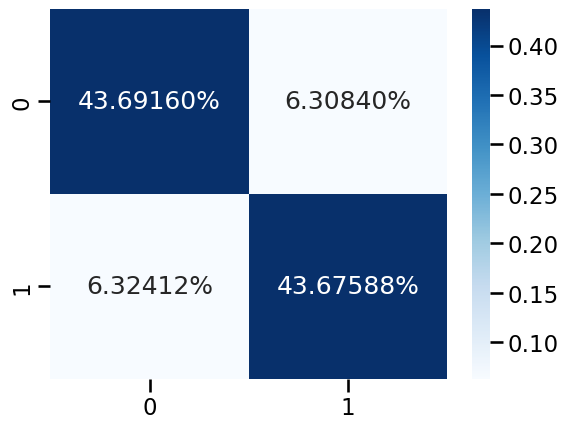

In [18]:
sns.set_context('talk')
ffcnn_cm = confusion_matrix(y_test, np.where(ffcnnxgy_hat > 0.5, 1, 0))
ffcnn_ax = sns.heatmap(ffcnn_cm/np.sum(ffcnn_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("ffcnn+xgb confusion matrix.png", dpi = 1200)

In [ ]:
##############################################################################################################################

In [ ]:
##############################################################################################################################

In [8]:
#For conv2d

In [9]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 conv2d (Conv2D)             (64, 32, 32, 32)          160       
                                                                 
 conv2d_1 (Conv2D)           (64, 32, 32, 32)          4128      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 32, 16, 16)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (64, 64, 16, 16)          18496     
                                                                 
 conv2d_3 (Conv2D)           (64, 64, 16, 16)          36928     
                                                             

In [10]:
cnn_intermediate_layer_model = keras.Model(inputs=model2.inputs, outputs=model2.get_layer("dense_1").output)

In [11]:
cnn_intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 conv2d (Conv2D)             (64, 32, 32, 32)          160       
                                                                 
 conv2d_1 (Conv2D)           (64, 32, 32, 32)          4128      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 32, 16, 16)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (64, 64, 16, 16)          18496     
                                                                 
 conv2d_3 (Conv2D)           (64, 64, 16, 16)          36928     
                                                             

In [12]:
cnn_intermediate_output = cnn_intermediate_layer_model.predict(train, steps = X_train.shape[0]//64) 

156250/156250 [==============================] - 424s 3ms/step


In [13]:
cnn_intermediate_test_output = cnn_intermediate_layer_model.predict(test, steps = X_test.shape[0]//64)

78125/78125 [==============================] - 234s 3ms/step


In [14]:
xgb.fit(cnn_intermediate_output, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1.2, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [15]:
xgb_predtest = xgb.predict(cnn_intermediate_test_output)

In [16]:
# Evaluate on test set
cnnxgy_hat = xgb.predict_proba(cnn_intermediate_test_output)[:, 1]
cnnfpr_xg, cnntpr_xg, _ = roc_curve(y_test, cnnxgy_hat)
cnnxgroc_auc = auc(cnnfpr_xg, cnntpr_xg)
print('Test ROC AUC:', cnnxgroc_auc)

Test ROC AUC: 0.9462232591203202


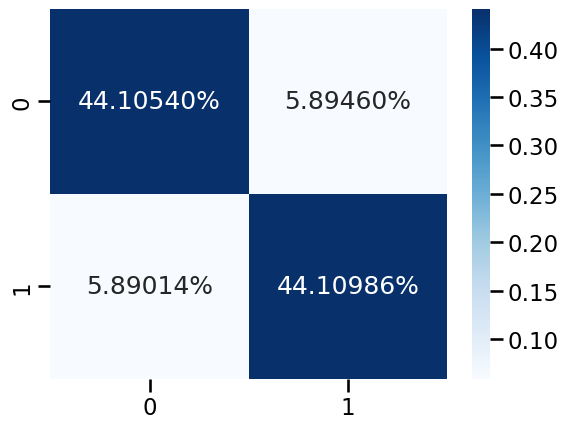

In [23]:
sns.set_context('talk')
cnn_cm = confusion_matrix(y_test, np.where(cnnxgy_hat>0.5, 1, 0))
cnn_ax = sns.heatmap(cnn_cm/np.sum(cnn_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("traditional_cnn+xgb confusion matrix.png", dpi = 1200)

In [ ]:
##############################################################################################################################

In [ ]:
##############################################################################################################################

In [ ]:
#For a stack model

In [8]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 conv2d_4 (Conv2D)           (64, 32, 32, 32)          160       
                                                                 
 conv2d_5 (Conv2D)           (64, 32, 32, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 32, 16, 16)         0         
 2D)                                                             
                                                                 
 fourier_convolution2d_4 (Fo  (64, 64, 16, 16)         8192      
 urierConvolution2D)                                             
                                                                 
 fourier_convolution2d_5 (Fo  (64, 64, 16, 16)         1638

In [11]:
stack_intermediate_layer_model = keras.Model(inputs=model3.inputs, outputs=model3.get_layer("dense_7").output)

In [12]:
stack_intermediate_layer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1, 32, 32)]         0         
                                                                 
 conv2d_4 (Conv2D)           (64, 32, 32, 32)          160       
                                                                 
 conv2d_5 (Conv2D)           (64, 32, 32, 32)          4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 32, 16, 16)         0         
 2D)                                                             
                                                                 
 fourier_convolution2d_4 (Fo  (64, 64, 16, 16)         8192      
 urierConvolution2D)                                             
                                                                 
 fourier_convolution2d_5 (Fo  (64, 64, 16, 16)         1638

In [14]:
stack_intermediate_output = stack_intermediate_layer_model.predict(train, steps = X_train.shape[0]//64) 

156250/156250 [==============================] - 515s 3ms/step


In [15]:
stack_intermediate_test_output = stack_intermediate_layer_model.predict(test, steps = X_test.shape[0]//64)

78125/78125 [==============================] - 374s 5ms/step


In [18]:
xgb.fit(stack_intermediate_output, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.0025, min_split_loss=0.1, missing=nan,
              monotone_constraints=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [19]:
stackxgb_predtest = xgb.predict(stack_intermediate_test_output)

In [20]:
# Evaluate on test set
stackxgy_hat = xgb.predict_proba(stack_intermediate_test_output)[:, 1]
stackxg_fpr, stackxg_tpr, _ = roc_curve(y_test, stackxgy_hat)
stackxgroc_auc = auc(stackxg_fpr, stackxg_tpr)
print('Test ROC AUC:', stackxgroc_auc)

Test ROC AUC: 0.9457678645892796


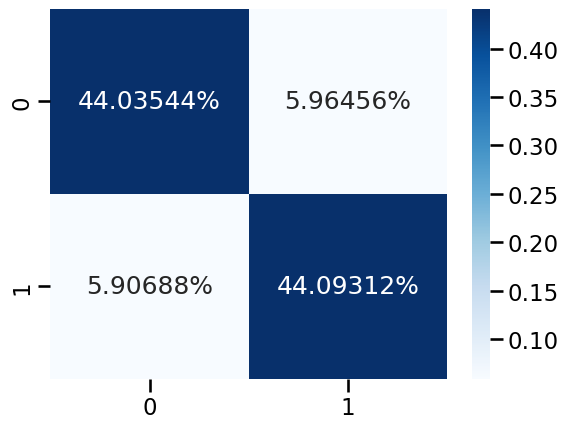

In [21]:
sns.set_context('talk')
stack_cm = confusion_matrix(y_test, np.where(stackxgy_hat > 0.5, 1, 0))
stack_ax = sns.heatmap(stack_cm/np.sum(stack_cm), annot=True, fmt='.5%', cmap='Blues')
plt.savefig("stack+xgb confusion matrix.png", dpi = 1200)